# Import packages

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ast

import datetime


from geopy.distance import geodesic
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import ipywidgets
# import geocoder
# import geopy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# parameter opimization
from sklearn.model_selection import GridSearchCV

# Validation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score

# Read Data

## Reload the data

In [178]:
dataframe = pd.read_csv('full_data.gz',compression='gzip')

## Describe Data

In [179]:
# check if the 537 taxis are in the dataframe
print('there are {:,} data points'.format(len(dataframe)))
print('and {} taxis in the dataset'.format(len(dataframe.taxi_id.unique())))

there are 11,220,058 data points
and 537 taxis in the dataset


In [180]:
# extract a sample to work - 1/100 
#df = dataframe.iloc[0: int(len(dataframe)/10), :]
df = dataframe.copy()
df.reset_index(inplace=True, drop = True)
print('sample size: {:,} data points'.format(len(df)))

sample size: 11,220,058 data points


In [181]:
# columns
df.columns

Index(['latitude', 'longitude', 'in_ride', 'epoch_time', 'taxi_id'], dtype='object')

In [182]:
# Null values for each column
df.isnull().sum()

latitude      0
longitude     0
in_ride       0
epoch_time    0
taxi_id       0
dtype: int64

In [183]:
# Transform epoch to datatime yyyy-mm-dd hh:mm:ss + drop epoch
df.loc[:,"date_time"] = df.loc[:,'epoch_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df.drop('epoch_time', axis = 1, inplace = True)

In [184]:
# clean data types
df.loc[:,'date_time'] = pd.to_datetime(df.loc[:,'date_time'])
df.loc[:,'in_ride'] = df.loc[:,'in_ride'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11220058 entries, 0 to 11220057
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   latitude   float64       
 1   longitude  float64       
 2   in_ride    object        
 3   taxi_id    object        
 4   date_time  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 428.0+ MB


In [185]:
# Studied sample timeframe
start_date = df.date_time.min()
end_date = df.date_time.max()

# Studied sample covered geo area
max_lat = df.latitude.max()
min_lat = df.latitude.min()
max_lon=df.longitude.max()
min_lon = df.longitude.min()

print('the sample start on {} and end on {}. \nThe maximum latitude is {} and the minimum {}. \nThe maximum longitude is {} and the minimum is {}'.format(start_date, end_date, max_lat, min_lat, max_lon, min_lon))

the sample start on 2008-05-17 12:00:04 and end on 2008-06-10 11:25:34. 
The maximum latitude is 50.30546 and the minimum 32.8697. 
The maximum longitude is -115.56218 and the minimum is -127.08143


In [186]:
# Sort data
df = df.sort_values(by=['taxi_id',"date_time"])

# Features Extraction
## Extract pick-up and drop-off observation

Hypothesis: When a taxi "in_ride" passes from 0 to 1; it's a pick-up observation and the contrary is a drop-off. 
Action is then: 
1. Pick-up
2. Drop-off
3. Driving (in between pick-up and drop-off)

Make sure the id of the taxi is the same as the previous one, otherwise it's another trip

In [12]:
# create function Pickup / drop off/ inbetween 
def action(val1, val2, id1, id2):
    if (val1 == 0) & (val2 == 1) & (id1 == id2):
        action = "pick-up"
    elif (val1 == 1) & (val2==0) & (id1 == id2):
        action = "drop-off"
    else:
        action = "driving"
    return action

In [13]:
# Apply function (-> to be improved)
action_list=[]
for i in range(len(df)):
    if i == 0:
        action_list.append("driving")
    else:
        action_list.append(action(df.loc[i-1, "in_ride"],df.loc[i, "in_ride"],df.loc[i-1, "taxi_id"],df.loc[i, "taxi_id"]))

In [14]:
# Assign action list to action series in df
df['action'] = action_list

## Extract Distance
<p>Use geodisc : The geodesic distance is the shortest distance on the surface of an ellipsoidal model of the earth</p>
<p>An alternative (but less accurate) of geodisc would be harvesine. This <a href="https://stackoverflow.com/questions/38248046/is-the-haversine-formula-or-the-vincentys-formula-better-for-calculating-distan">stakeoverflow post</a> explain, in a nutshell, the difference between both of these measures.</p>

In [15]:
df["coordinates"] = list(zip(df['latitude'],df['longitude']))

In [17]:
# Find distance between each point when the taxi_id is the same 
dist_list = []
for i in range(len(df)):
    if i == 0:
        dist_list.append(0)
    elif df.loc[i-1,'taxi_id'] !=  df.loc[i,'taxi_id']:
        dist_list.append(0)
    else:
        origin = df.loc[i-1,'coordinates']
        destination = df.loc[i,'coordinates']        
        dist_list.append(geodesic(origin, destination).miles)
        
df['distance'] = dist_list

In [18]:
df.head()

latitude  longitude in_ride     taxi_id           date_time   action  \
0  37.75153 -122.39447       0  new_abboip 2008-05-17 16:12:10  driving   
1  37.75149 -122.39447       0  new_abboip 2008-05-17 16:13:34  driving   
2  37.75149 -122.39447       0  new_abboip 2008-05-17 16:14:34  driving   
3  37.75149 -122.39446       0  new_abboip 2008-05-17 16:15:35  driving   
4  37.75144 -122.39449       0  new_abboip 2008-05-17 16:41:43  driving   

              coordinates  distance  
0  (37.75153, -122.39447)  0.000000  
1  (37.75149, -122.39447)  0.002759  
2  (37.75149, -122.39447)  0.000000  
3  (37.75149, -122.39446)  0.000548  
4  (37.75144, -122.39449)  0.003820

## Answer Q1 

- Assumption 1: This month is a representative sample of the whole year
- Assumption 2: taxi cab fleet is change at a rate of 15% per month  as from next month
- Assumption 3: average passenger vehicle emits 404g of CO2 per mile
- Assumption 4: an EV emits (directly) 0g of CO2 per mile

In [19]:
# potential CO2 reduction 

# Assumption 3
monthly_emission = df[df.in_ride == 0]['distance'].sum()*404

# Assumption 1
list_emission = [monthly_emission]*13

# Asuumption 2
rate = .85

list_updated = [round(x*(rate**ind),2) for ind ,x in enumerate(list_emission) if ind>0]
list_month = ['month {}'.format(str(i+1)) for i, x in enumerate(list_emission)]
df_emission = pd.DataFrame(zip(list_month, list_updated), columns = ['month','potential CO2 reduction'])
print(df_emission)
print('Potential CO2 reduction of {:,}T for the next 12 months'.format(round(df_emission['potential CO2 reduction'].sum()/1000000,2)))

       month  potential CO2 reduction
0    month 1             4.341453e+08
1    month 2             3.690235e+08
2    month 3             3.136700e+08
3    month 4             2.666195e+08
4    month 5             2.266265e+08
5    month 6             1.926326e+08
6    month 7             1.637377e+08
7    month 8             1.391770e+08
8    month 9             1.183005e+08
9   month 10             1.005554e+08
10  month 11             8.547209e+07
11  month 12             7.265128e+07
Potential CO2 reduction of 2,482.61T for the next 12 months


## Date

In [20]:
# Extract weekday, hour, day and minute
df['weekday'] = df.date_time.dt.weekday
df['hour'] = df.date_time.dt.hour
df['monthday'] = df.date_time.dt.day
df['minute'] = df.date_time.dt.minute

In [21]:
# New feature: Part_day - Split the day in Morning, day, end of day, night

def part_day(hour):
""" Assumptions
- Last call in san francisco = 2am
- People who take the most the cab are white collar: they go to work between 7 to 10 and get out of work between 16 and 20
- night life starts after work: 20 and ends at the last call: 2am +  buffer of 1 hour 

""" 
    part = ""
    if (hour>=7) & (hour < 10):
        part = "morning"
    elif (hour >= 10) & (hour < 16):
        part = "day"
    elif (hour >= 16) & (hour < 20):
        part = "end of day"
    elif (hour >=20) & (hour < 2):
        part = "evening"
    else:
        part = "night"
    
    return part

In [22]:
# Add feature to df
df['part_of_day'] = df.hour.apply(part_day)

In [23]:
df.head()

latitude  longitude in_ride     taxi_id           date_time   action  \
0  37.75153 -122.39447       0  new_abboip 2008-05-17 16:12:10  driving   
1  37.75149 -122.39447       0  new_abboip 2008-05-17 16:13:34  driving   
2  37.75149 -122.39447       0  new_abboip 2008-05-17 16:14:34  driving   
3  37.75149 -122.39446       0  new_abboip 2008-05-17 16:15:35  driving   
4  37.75144 -122.39449       0  new_abboip 2008-05-17 16:41:43  driving   

              coordinates  distance  weekday  hour  monthday  minute  \
0  (37.75153, -122.39447)  0.000000        5    16        17      12   
1  (37.75149, -122.39447)  0.002759        5    16        17      13   
2  (37.75149, -122.39447)  0.000000        5    16        17      14   
3  (37.75149, -122.39446)  0.000548        5    16        17      15   
4  (37.75144, -122.39449)  0.003820        5    16        17      41   

  part_of_day  
0  end of day  
1  end of day  
2  end of day  
3  end of day  
4  end of day

In [24]:
# Distance on the road without and with passenger(s) for each part of the day. 
df.groupby(['in_ride','part_of_day'])['distance'].sum()

in_ride  part_of_day
0        day            274699.652768
         end of day     223982.455485
         morning        167002.292311
         night          598570.901327
1        day            225795.393719
         end of day     270024.225231
         morning        246699.578111
         night          865962.076021
Name: distance, dtype: float64

Comment: During the day, the drivers make a lot of loss (+ CO2 Emission) by driving without passenger. 

In [25]:
# Add weekday feature: workday or weekend?
def part_week(weekday):
    
    if weekday < 5:
        partweek = "workday"
    else:
        partweek="weekend"
    return partweek

In [26]:
df['partweek'] = df['weekday'].apply(part_week)

# Visual EDA

In [104]:
# set style
sns.set_style("darkgrid")
c = ['darkcyan','blue','navy','deepskyblue']

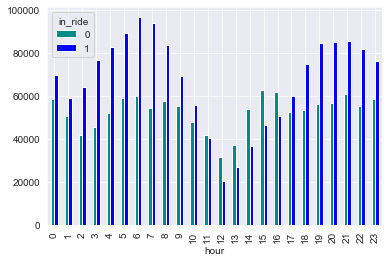

In [106]:
# Distance ride per hour when the cab is occupied (orange) and when it is not (blue)
pd.pivot_table(df, index= 'hour', columns = 'in_ride', values = 'distance', aggfunc = "sum").plot.bar(color=c);

Same conclusion as above;  between 11am and 4pm the cabs tend to be emptier 

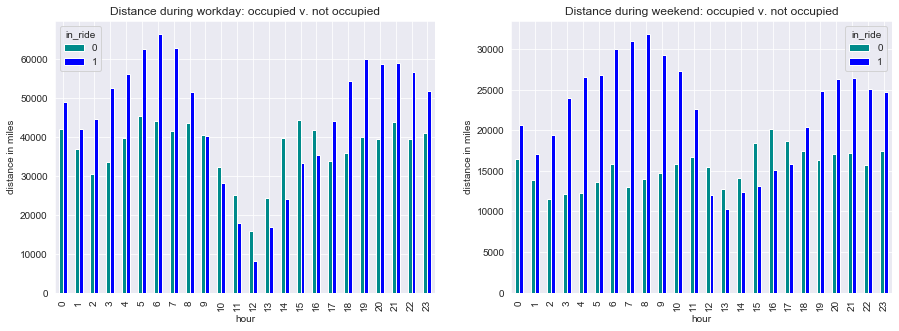

In [108]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
# same analysis but just for the workday 
pd.pivot_table(df[df.partweek=="workday"], index= 'hour', columns = 'in_ride', values = 'distance', aggfunc = "sum").plot.bar(ax=ax[0],color = c)
ax[0].set_title('Distance during workday: occupied v. not occupied')
ax[0].set_ylabel('distance in miles')
# same analysis but just for the weekend 
pd.pivot_table(df[df.partweek=="weekend"], index= 'hour', columns = 'in_ride', values = 'distance', aggfunc = "sum").plot.bar(ax=ax[1], color=c)
ax[1].set_title('Distance during weekend: occupied v. not occupied')
ax[1].set_ylabel('distance in miles');

The trend is the same during the weekend. However, the utilization seems to be way better.

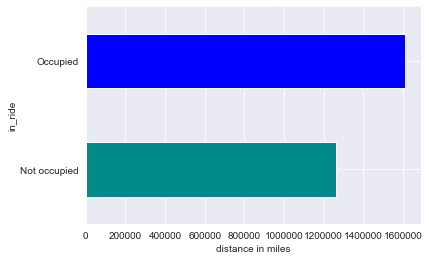

In [109]:
# distance for the analyzed month
df.groupby('in_ride')['distance'].sum().rename(index={0:'Not occupied', 1:'Occupied'}).plot.barh(color=c)
plt.xlabel('distance in miles');

There is a big opportunity in the dispatching optimization. The taxi rides empty as much as it does when it is occupied. 

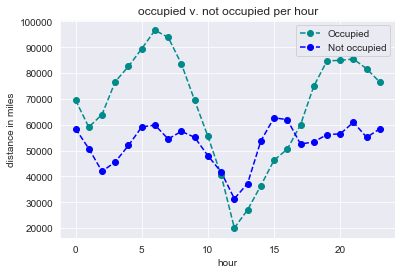

In [111]:
# utilization  per hour 
df[df.in_ride == 1].groupby("hour")['distance'].sum().plot(linestyle = "--", marker = 'o', color=c)
df[df.in_ride == 0].groupby("hour")['distance'].sum().plot(linestyle = "--", marker = 'o', color = c[1])
plt.ylabel('distance in miles')
plt.title('occupied v. not occupied per hour')
plt.legend(['Occupied','Not occupied'], loc = "best",bbox_to_anchor=(1, 1));

Same chart as above; A focus on 11-16h

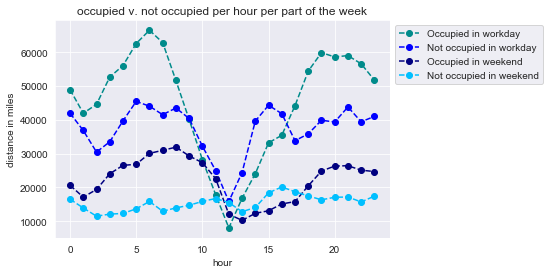

In [112]:
# utilization rate per hour split by weekday and weekend

df[(df.in_ride == 1) & (df.partweek == "workday")].groupby("hour")['distance'].sum().plot(linestyle = "--", marker = 'o', color=c[0])
df[(df.in_ride == 0) & (df.partweek == "workday") ].groupby("hour")['distance'].sum().plot(linestyle = "--", marker = 'o', color=c[1])

df[(df.in_ride == 1) & (df.partweek == "weekend")].groupby("hour")['distance'].sum().plot(linestyle = "--", marker = 'o', color=c[2])
df[(df.in_ride == 0) & (df.partweek == "weekend") ].groupby("hour")['distance'].sum().plot(linestyle = "--", marker = 'o', color=c[3])

plt.ylabel('distance in miles')
plt.title('occupied v. not occupied per hour per part of the week')
plt.legend(['Occupied in workday','Not occupied in workday','Occupied in weekend','Not occupied in weekend'], loc = "best",bbox_to_anchor=(1, 1));

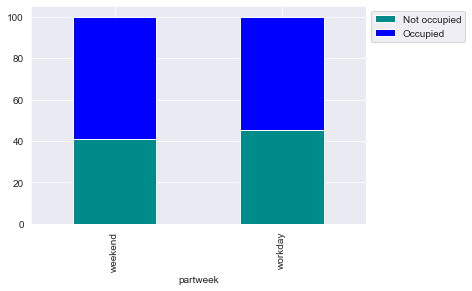

In [103]:
#df.groupby(["partweek","in_ride"])['distance'].sum().plot.bar(stacked = 'True')
pd.pivot_table(df, index = "partweek", columns="in_ride", values="distance", aggfunc = "sum").apply(lambda x: x*100/sum(x), axis=1).plot.bar(stacked = True, color = ['darkcyan','blue'])
plt.legend(['Not occupied','Occupied'], loc = "best",bbox_to_anchor=(1, 1));

More or less same conclusion for both weekend and workday with a stress on the fact that on workday, the "utilization" of the taxi is lower.

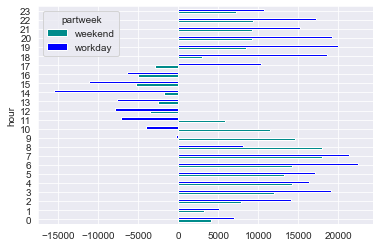

In [114]:
# total
pd.pivot_table(df, index= 'hour', columns = 'partweek', values = 'distance_adjusted', aggfunc = "sum").plot.barh(color=c);

# New dataframe
<p> The purpose of this section is to change the dataframe in order to have 1 obervation = 1 trip.<br>
    The assumption is that each subsequent 1 or 0 in the feature 'in_ride' represents a trip (e.g. 4 "1" in a row = one trip).</p>
    
## Adapt the data

In [37]:
# df_trace = df.groupby(["in_ride", df["in_ride"].ne(df["in_ride"].shift()).cumsum()])["coordinates"].apply(list).reset_index(level=1, drop=True)
# outcome1['first'].values
# df.set_index("coordinates").loc[outcome1]

In [38]:
# add trip id to the dataframe: if same taxi id and in_ride, then it's a trip 
trip_id = 0
list_tripid=[]
for i in range(len(df)):
    if i == 0:
        list_tripid.append(trip_id)
    elif (df.loc[i,'in_ride'] == df.loc[i-1, 'in_ride']) & (df.loc[i,'taxi_id'] == df.loc[i-1, 'taxi_id']):
        list_tripid.append(trip_id)
    else:
        trip_id+=1
        list_tripid.append(trip_id)

df['trip_id'] = list_tripid    

In [39]:
# clean coordinates
df['coordinates'] = df['coordinates'].apply(lambda x: list(x))
df['coordinates'] = df['coordinates'].apply(lambda x: str(x))

In [40]:
# Put everything together
df_analysis2 = df.groupby(['taxi_id','trip_id']).agg({'date_time': ['min','max'], 'distance':'sum', 'coordinates':','.join, 'in_ride': 'max'})

In [41]:
# Reset index 
df_analysis2.reset_index(inplace = True)
df_analysis2.reset_index(col_level=0, drop = True, inplace = True)
df_analysis2.columns.droplevel()
df_analysis2.columns = ['taxi_id','trip_id','pickup_time','dropoff_time','distance','polyline','in_ride']

In [42]:
df_analysis2.head()

taxi_id  trip_id         pickup_time        dropoff_time  distance  \
0  new_abboip        0 2008-05-17 16:12:10 2008-05-17 16:50:44  0.216159   
1  new_abboip        1 2008-05-17 16:51:10 2008-05-17 16:55:58  1.397034   
2  new_abboip        2 2008-05-17 16:56:00 2008-05-17 17:17:55  2.221945   
3  new_abboip        3 2008-05-17 17:18:06 2008-05-17 17:21:48  0.620227   
4  new_abboip        4 2008-05-17 17:21:50 2008-05-17 17:43:15  3.183110   

                                            polyline  in_ride  
0  [37.75153, -122.39447],[37.75149, -122.39447],...        0  
1  [37.74977, -122.39724],[37.74896, -122.40619],...        1  
2  [37.7558, -122.41441],[37.76172, -122.41496],[...        0  
3  [37.75053, -122.42086],[37.75086, -122.42154],...        1  
4  [37.75177, -122.43095],[37.75153, -122.4311399...        0

In [43]:
# extract the duration of the trip
df_analysis2['duration'] = df_analysis2.dropoff_time - df_analysis2.pickup_time

# transform trajet to list 
df_analysis2['polyline'] = df_analysis2['polyline'].apply(lambda x : list(ast.literal_eval(x)))

# -> more condition; see next cell  
#extract pick-up and drop-off locations 
#df_analysis2['pickup_coordinate'] = [x[0] if len(x)>2 else x for x in df_analysis2.trajet]
#df_analysis2['dropoff_coordinate'] = [x[-1] if len(x)>2 else x for x in df_analysis2.trajet]

In [44]:
# Pick-up and drop-off location extraction
pickup_coordinate=[]
dropoff_coordinate=[]
for i in range(len(df_analysis2)):
    if len(df_analysis2.polyline[i]) <=2:
        if 'list' in str(type(df_analysis2.polyline[i][0])):
            pickup_coordinate.append(df_analysis2.polyline[i][0])
            dropoff_coordinate.append(df_analysis2.polyline[i][-1])
        else:
            pickup_coordinate.append(df_analysis2.polyline[i])
            dropoff_coordinate.append(df_analysis2.polyline[i])
    else:
        pickup_coordinate.append(df_analysis2.polyline[i][0])
        dropoff_coordinate.append(df_analysis2.polyline[i][-1])

In [45]:
df_analysis2['dropoff_coordinate'] = dropoff_coordinate
df_analysis2['pickup_coordinate'] = pickup_coordinate

In [46]:
df_analysis2.head()

taxi_id  trip_id         pickup_time        dropoff_time  distance  \
0  new_abboip        0 2008-05-17 16:12:10 2008-05-17 16:50:44  0.216159   
1  new_abboip        1 2008-05-17 16:51:10 2008-05-17 16:55:58  1.397034   
2  new_abboip        2 2008-05-17 16:56:00 2008-05-17 17:17:55  2.221945   
3  new_abboip        3 2008-05-17 17:18:06 2008-05-17 17:21:48  0.620227   
4  new_abboip        4 2008-05-17 17:21:50 2008-05-17 17:43:15  3.183110   

                                            polyline  in_ride duration  \
0  [[37.75153, -122.39447], [37.75149, -122.39447...        0 00:38:34   
1  [[37.74977, -122.39724], [37.74896, -122.40619...        1 00:04:48   
2  [[37.7558, -122.41441], [37.76172, -122.41496]...        0 00:21:55   
3  [[37.75053, -122.42086], [37.75086, -122.42154...        1 00:03:42   
4  [[37.75177, -122.43095], [37.75153, -122.43113...        0 00:21:25   

       dropoff_coordinate       pickup_coordinate  
0  [37.74978, -122.39709]  [37.75153, -122.39447]  
1  [37.75552, -122.41438]  [37.74977, -122.39724]  
2  [37.75053, -122.42086]   [37.7558, -122.41441]  
3  [37.75177, -122.43095]  [37.75053, -122.42086]  
4  [37.77181, -122.41836]  [37.75177, -122.43095]

In [47]:
df_analysis2[df_analysis2.in_ride == 1]['duration'].describe()

count                    464048
mean     0 days 00:10:23.943889
std      0 days 00:11:05.037259
min             0 days 00:00:00
25%             0 days 00:05:22
50%             0 days 00:08:30
75%             0 days 00:13:06
max             1 days 09:13:35
Name: duration, dtype: object

## Features extraction

In [48]:

df_analysis2['pickup_weekday'] = df_analysis2.pickup_time.dt.weekday
df_analysis2['pickup_weekdayname'] = df_analysis2.pickup_time.dt.day_name()
df_analysis2['pickup_hour'] = df_analysis2.pickup_time.dt.hour
df_analysis2['dropoff_hour'] = df_analysis2.dropoff_time.dt.hour
df_analysis2['pickup_monthday'] = df_analysis2.pickup_time.dt.day
df_analysis2['pickup_minute'] = df_analysis2.pickup_time.dt.minute
df_analysis2['dropoff_minute'] = df_analysis2.dropoff_time.dt.minute

## Analysis 3 - only occupied trips

In [49]:
# Take only the occupied trip 
df_analysis3 = df_analysis2[df_analysis2.in_ride == 1]

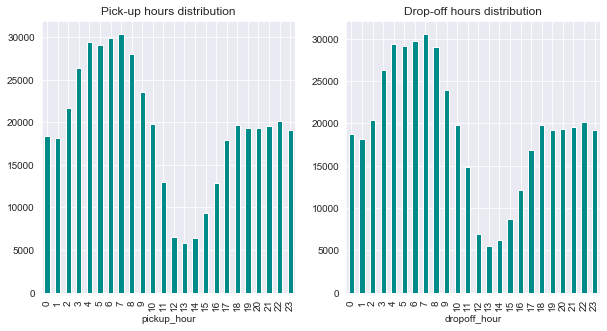

In [116]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_analysis3[df_analysis3.in_ride == 1].groupby(['pickup_hour'])['taxi_id'].count().plot.bar(ax=ax[0], color=c[0])
ax[0].set_title('Pick-up hours distribution')

df_analysis3[df_analysis3.in_ride == 1].groupby(['dropoff_hour'])['taxi_id'].count().plot.bar(ax=ax[1],color=c[0])
ax[1].set_title('Drop-off hours distribution');


There are way less demand between 11 and 16 and too much supply

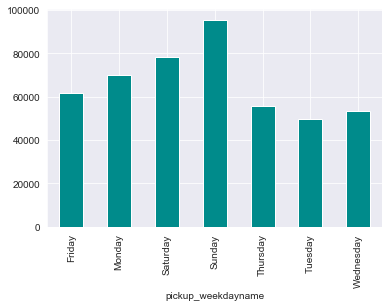

In [117]:
df_analysis3[df_analysis3.in_ride == 1].groupby(['pickup_weekdayname'])['taxi_id'].count().plot.bar(color=c[0]);

The taxi demand is very high during the weekend (but the distance travelled are lower?)

In [55]:
# Extract lat, lon for pick-up and drop-off locations
df_analysis3.loc[:,'pickup_lat'] = [x[0] for x in df_analysis3.pickup_coordinate.tolist()]
df_analysis3.loc[:,'pickup_lon'] = [x[1] for x in df_analysis3.pickup_coordinate.tolist()]

df_analysis3.loc[:,'dropoff_lat'] = [x[0] for x in df_analysis3.dropoff_coordinate.tolist()]
df_analysis3.loc[:,'dropoff_lon'] = [x[1] for x in df_analysis3.dropoff_coordinate.tolist()]

/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [56]:
df_analysis3.head()

taxi_id  trip_id         pickup_time        dropoff_time   distance  \
1  new_abboip        1 2008-05-17 16:51:10 2008-05-17 16:55:58   1.397034   
3  new_abboip        3 2008-05-17 17:18:06 2008-05-17 17:21:48   0.620227   
5  new_abboip        5 2008-05-17 17:43:51 2008-05-17 17:45:51   0.040165   
7  new_abboip        7 2008-05-17 17:46:08 2008-05-17 18:02:46  12.453853   
9  new_abboip        9 2008-05-17 18:18:40 2008-05-17 18:34:28   3.130575   

                                            polyline  in_ride duration  \
1  [[37.74977, -122.39724], [37.74896, -122.40619...        1 00:04:48   
3  [[37.75053, -122.42086], [37.75086, -122.42154...        1 00:03:42   
5  [[37.77173, -122.41838], [37.77156, -122.41834...        1 00:02:00   
7  [[37.77181, -122.41833], [37.77021, -122.41783...        1 00:16:38   
9  [[37.7524, -122.41842], [37.75402, -122.4186],...        1 00:15:48   

       dropoff_coordinate       pickup_coordinate  ...  pickup_weekdayname  \
1  [37.75552, -122.41438]  [37.74977, -122.39724]  ...            Saturday   
3  [37.75177, -122.43095]  [37.75053, -122.42086]  ...            Saturday   
5  [37.77188, -122.41825]  [37.77173, -122.41838]  ...            Saturday   
7  [37.61765, -122.38738]  [37.77181, -122.41833]  ...            Saturday   
9   [37.7916, -122.41249]   [37.7524, -122.41842]  ...            Saturday   

  pickup_hour  dropoff_hour  pickup_monthday  pickup_minute  dropoff_minute  \
1          16            16               17             51              55   
3          17            17               17             18              21   
5          17            17               17             43              45   
7          17            18               17             46               2   
9          18            18               17             18              34   

   pickup_lat  pickup_lon  dropoff_lat  dropoff_lon  
1    37.74977  -122.39724     37.75552   -122.41438  
3    37.75053  -122.42086     37.75177   -122.43095  
5    37.77173  -122.41838     37.77188   -122.41825  
7    37.77181  -122.41833     37.61765   -122.38738  
9    37.75240  -122.41842     37.79160   -122.41249  

[5 rows x 21 columns]

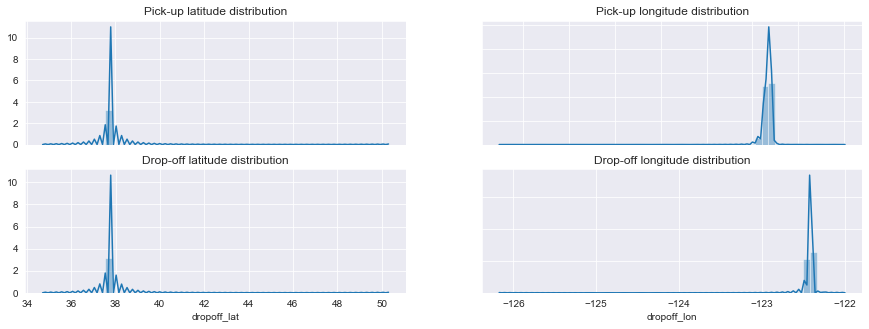

In [57]:
# Plot distribution of pick-up/ drop-off lat/lon
figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
sns.distplot(df_analysis3['pickup_lat'],ax=ax[0,0])
ax[0,0].set_title('Pick-up latitude distribution');

sns.distplot(df_analysis3['pickup_lon'],ax=ax[0,1])
ax[0,1].set_title('Pick-up longitude distribution');

sns.distplot(df_analysis3['dropoff_lat'],ax=ax[1,0])
ax[1,0].set_title('Drop-off latitude distribution');

sns.distplot(df_analysis3['dropoff_lon'],ax=ax[1,1])
ax[1,1].set_title('Drop-off longitude distribution');

for axe in ax.flat:
    axe.label_outer()

In [58]:
# Extract part of the day
df_analysis3.loc[:,'part_of_day'] = df.hour.apply(part_day)

/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [60]:

# # groupby 
# outcome1 = pd.DataFrame(df.groupby(["in_ride", df["in_ride"].ne(df["in_ride"].shift()).cumsum()],
#                         sort=False)["coordinates"].apply(list).reset_index(level=1, drop=True)).reset_index()
# display(outcome1.head())
# # extract the first and last element 
# outcome1["first"] = outcome1.coordinates.apply(lambda x: x[0])
# outcome1["last"] = outcome1.coordinates.apply(lambda x: x[-1])
# display(outcome1.head())

# # find those first and last element in the original dataset 
# outcome1["Start"] = df.set_index('coordinates').loc[outcome1["first"].values,:]["date_time"].values
# outcome1["End"] = df.set_index('coordinates').loc[outcome1["last"].values,:]["date_time"].values
# display(outcome1.head())
# # drop unnecessary columns 
# outcome1.drop(["first","last"],axis=1)
# display(outcome1.head())
# # difference
# outcome1["difference"] = outcome1["End"] - outcome1["Start"]
# display(outcome1.head())

# Geospatial analysis

In [62]:
# Function to generate a basemap
def generateBaseMap(default_location=[df.latitude[0], df.longitude[0]], default_zoom_start=10):
    base_map = folium.Map(location=default_location, 
                          control_scale=True, 
                          zoom_start=default_zoom_start,
                         tiles='https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png',
                         attr='grey')
    return base_map

## TODO - Marker pickup. dropoff + another map with heatmap circulation occupied in one color  and not occupied in another one

In [63]:
# df_pickup: Pickup lat/lon dataframe
df_pickup = pd.DataFrame({
    "date":df_analysis3.head(5000)["pickup_time"].values,
    "lat":df_analysis3.head(5000)["pickup_lat"].values,
    "lon":df_analysis3.head(5000)["pickup_lon"].values
})

# df_dropoff: Dropoff lat/lon dataframe
df_dropoff = pd.DataFrame({
    "date":df_analysis3.head(5000)["dropoff_time"].values,
    "lat":df_analysis3.head(5000)["dropoff_lat"].values,
    "lon":df_analysis3.head(5000)["dropoff_lon"].values
})

In [64]:
# Map pickup v. dropff
basemap = generateBaseMap()
for i, r in df_pickup.iterrows():
    folium.CircleMarker(location=[r["lat"],r["lon"]], radius=0.5, color="red",min_opacity=0.5, max_opacity=0.8).add_to(basemap)

for i, r in df_dropoff.iterrows():
    folium.CircleMarker(location=[r["lat"],r["lon"]], radius=0.5, color="blue",min_opacity=0.5, max_opacity=0.8).add_to(basemap)    
    
basemap

In [65]:
# Marker pickup

# from folium.plugins import HeatMap
# df_analysis3.loc[:,'count'] = 1
# base_map=generateBaseMap()
# HeatMap(data=df_analysis[['latitude','longitude','count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), 
#         radius=8, 
#         max_zoom=13,
#        gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(base_map)
# geojson = r"map\SanFrancisco.Neighborhoods.json"
# g = folium.GeoJson(geojson, name="geojson").add_to(base_map)
# base_map

In [66]:
# Pickup density zone

df_pickup.loc[:,'count'] = 1
base_map=generateBaseMap()
HeatMap(data=df_pickup[['lat','lon','count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), 
        radius=8, 
        max_zoom=13,
       gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(base_map)

# add as an optional layer
#geojson = r"map\SanFrancisco.Neighborhoods.json"
#g = folium.GeoJson(geojson, name="geojson").add_to(base_map)
base_map

In [68]:
# Dropoff density zone

df_dropoff.loc[:,'count'] = 1
base_map=generateBaseMap()
HeatMap(data=df_dropoff[['lat','lon','count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), 
        radius=8, 
        max_zoom=13,
       gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(base_map)
#geojson = r"map\SanFrancisco.Neighborhoods.json"
#g = folium.GeoJson(geojson, name="geojson").add_to(base_map)
# folium.GeoJsonTooltip(fields=['neighborhood']).add_to(g)
base_map

In [69]:
# Evolution  pick-up location per hour
df_hour_list = []
for hour in df_analysis3.pickup_hour.sort_values().unique():
    df_hour_list.append(df_analysis3.loc[df_analysis3.pickup_hour == hour, ['pickup_lat', 'pickup_lon', 'count']].groupby(['pickup_lat', 'pickup_lon']).sum().reset_index().values.tolist())

base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

NameError: name 'df_analysis' is not defined

# Modelling

## Data preparation

In [71]:
df_analysis3.head()

taxi_id  trip_id         pickup_time        dropoff_time   distance  \
1  new_abboip        1 2008-05-17 16:51:10 2008-05-17 16:55:58   1.397034   
3  new_abboip        3 2008-05-17 17:18:06 2008-05-17 17:21:48   0.620227   
5  new_abboip        5 2008-05-17 17:43:51 2008-05-17 17:45:51   0.040165   
7  new_abboip        7 2008-05-17 17:46:08 2008-05-17 18:02:46  12.453853   
9  new_abboip        9 2008-05-17 18:18:40 2008-05-17 18:34:28   3.130575   

                                            polyline  in_ride duration  \
1  [[37.74977, -122.39724], [37.74896, -122.40619...        1 00:04:48   
3  [[37.75053, -122.42086], [37.75086, -122.42154...        1 00:03:42   
5  [[37.77173, -122.41838], [37.77156, -122.41834...        1 00:02:00   
7  [[37.77181, -122.41833], [37.77021, -122.41783...        1 00:16:38   
9  [[37.7524, -122.41842], [37.75402, -122.4186],...        1 00:15:48   

       dropoff_coordinate       pickup_coordinate  ...  pickup_hour  \
1  [37.75552, -122.41438]  [37.74977, -122.39724]  ...           16   
3  [37.75177, -122.43095]  [37.75053, -122.42086]  ...           17   
5  [37.77188, -122.41825]  [37.77173, -122.41838]  ...           17   
7  [37.61765, -122.38738]  [37.77181, -122.41833]  ...           17   
9   [37.7916, -122.41249]   [37.7524, -122.41842]  ...           18   

  dropoff_hour  pickup_monthday  pickup_minute  dropoff_minute  pickup_lat  \
1           16               17             51              55    37.74977   
3           17               17             18              21    37.75053   
5           17               17             43              45    37.77173   
7           18               17             46               2    37.77181   
9           18               17             18              34    37.75240   

   pickup_lon  dropoff_lat  dropoff_lon  part_of_day  
1  -122.39724     37.75552   -122.41438   end of day  
3  -122.42086     37.75177   -122.43095   end of day  
5  -122.41838     37.77188   -122.41825   end of day  
7  -122.41833     37.61765   -122.38738   end of day  
9  -122.41842     37.79160   -122.41249   end of day  

[5 rows x 22 columns]

In [72]:
# Delta in lat and in long
df_analysis3.loc[:,"delta_lon"] = df_analysis3.loc[:,"pickup_lon"] - df_analysis3.loc[:,"dropoff_lon"]
df_analysis3.loc[:,"delta_lat"] = df_analysis3.loc[:,"pickup_lat"] - df_analysis3.loc[:,"dropoff_lat"]

/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [73]:
df_analysis3.head()

taxi_id  trip_id         pickup_time        dropoff_time   distance  \
1  new_abboip        1 2008-05-17 16:51:10 2008-05-17 16:55:58   1.397034   
3  new_abboip        3 2008-05-17 17:18:06 2008-05-17 17:21:48   0.620227   
5  new_abboip        5 2008-05-17 17:43:51 2008-05-17 17:45:51   0.040165   
7  new_abboip        7 2008-05-17 17:46:08 2008-05-17 18:02:46  12.453853   
9  new_abboip        9 2008-05-17 18:18:40 2008-05-17 18:34:28   3.130575   

                                            polyline  in_ride duration  \
1  [[37.74977, -122.39724], [37.74896, -122.40619...        1 00:04:48   
3  [[37.75053, -122.42086], [37.75086, -122.42154...        1 00:03:42   
5  [[37.77173, -122.41838], [37.77156, -122.41834...        1 00:02:00   
7  [[37.77181, -122.41833], [37.77021, -122.41783...        1 00:16:38   
9  [[37.7524, -122.41842], [37.75402, -122.4186],...        1 00:15:48   

       dropoff_coordinate       pickup_coordinate  ...  pickup_monthday  \
1  [37.75552, -122.41438]  [37.74977, -122.39724]  ...               17   
3  [37.75177, -122.43095]  [37.75053, -122.42086]  ...               17   
5  [37.77188, -122.41825]  [37.77173, -122.41838]  ...               17   
7  [37.61765, -122.38738]  [37.77181, -122.41833]  ...               17   
9   [37.7916, -122.41249]   [37.7524, -122.41842]  ...               17   

  pickup_minute  dropoff_minute  pickup_lat  pickup_lon  dropoff_lat  \
1            51              55    37.74977  -122.39724     37.75552   
3            18              21    37.75053  -122.42086     37.75177   
5            43              45    37.77173  -122.41838     37.77188   
7            46               2    37.77181  -122.41833     37.61765   
9            18              34    37.75240  -122.41842     37.79160   

   dropoff_lon  part_of_day  delta_lon  delta_lat  
1   -122.41438   end of day    0.01714   -0.00575  
3   -122.43095   end of day    0.01009   -0.00124  
5   -122.41825   end of day   -0.00013   -0.00015  
7   -122.38738   end of day   -0.03095    0.15416  
9   -122.41249   end of day   -0.00593   -0.03920  

[5 rows x 24 columns]

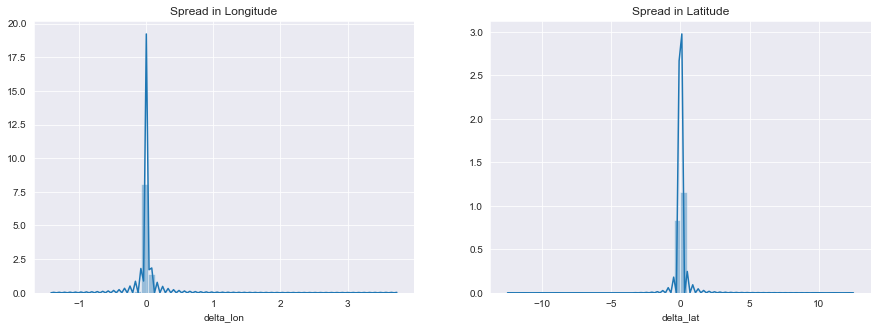

In [74]:
# Spot outliers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.distplot(df_analysis3.delta_lon, ax = ax[0])
ax[0].set_title('Spread in Longitude')
sns.distplot(df_analysis3.delta_lat, ax = ax[1])
ax[1].set_title('Spread in Latitude');

In [79]:
df_analysis3.delta_lon.describe()

count    464048.000000
mean         -0.000917
std           0.035068
min          -1.416690
25%          -0.013570
50%           0.000000
75%           0.014520
max           3.729930
Name: delta_lon, dtype: float64

In [80]:
# Remove outliers
df_outliers = df_analysis3[(df_analysis3.delta_lat<=.1) &
                          (df_analysis3.delta_lon<=.1) &
                          (df_analysis3.delta_lon>=-.1) &
                          (df_analysis3.delta_lat>=-.1)]

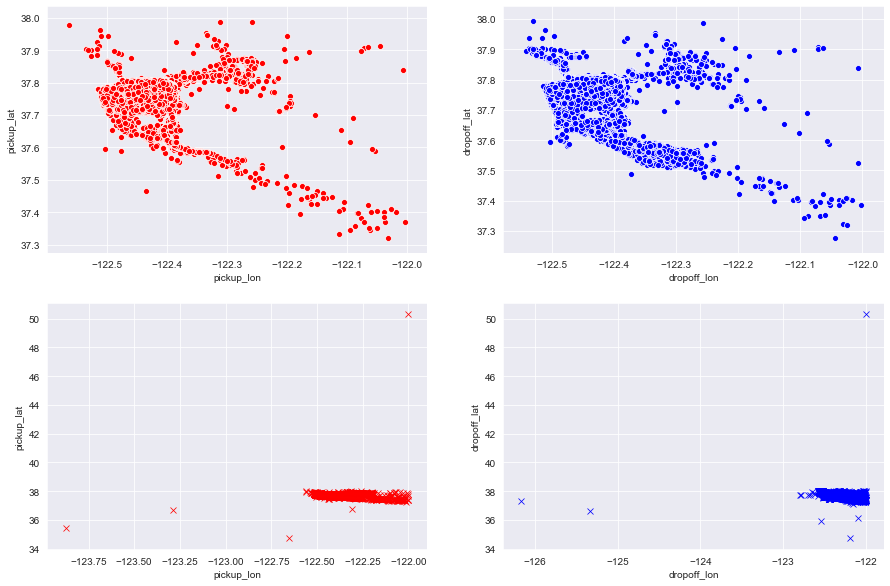

In [82]:
# Difference between dataset with/ without outliers
fig, ax = plt.subplots(2,2, figsize = (15,10))
sns.scatterplot(data = df_outliers, x='pickup_lon', y='pickup_lat', color = 'r', ax=ax[0,0])
sns.scatterplot(data = df_outliers, x='dropoff_lon', y='dropoff_lat', color = 'b', ax=ax[0,1]);
sns.scatterplot(data = df_analysis3, x='pickup_lon', y='pickup_lat', color = 'r', ax=ax[1,0], marker = 'x')
sns.scatterplot(data = df_analysis3, x='dropoff_lon', y='dropoff_lat', color = 'b', ax=ax[1,1], marker = 'x');

## Set Features/ Target

In [83]:
# model 1: Pickup_lon, Pickup_lat, day, hour
X = df_outliers[['pickup_lon','pickup_lat','pickup_weekday','pickup_hour']]
y = df_outliers[['dropoff_lat','dropoff_lon']]

In [84]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

## Model 1 - Random Forest

In [85]:
model1 = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=123))
model1 = model1.fit(X_train, y_train)

In [86]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

In [87]:
print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE test:{}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred)))

MSE train:5.0998929204218664e-05
MSE test;0.0003622757865995639
R2 score train:0.9108972978598638
R2 score test:0.3624799584025905


In [95]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['dropoff_lat','dropoff_lon'])

## Model 2 - Gradient Boosting 

In [124]:
# Model 2: 
from sklearn.ensemble import GradientBoostingRegressor 

model2 = MultiOutputRegressor(GradientBoostingRegressor(criterion = 'mse',learning_rate=.2, random_state=123))
model2.fit(X_train, y_train)




MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='mse',
                                                         init=None,
                                                         learning_rate=0.2,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,

In [128]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

In [129]:
print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE test:{}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred)))

MSE train:0.0003358821941368026
MSE test:0.0003405414945013273
R2 score train:0.4133844399217193
R2 score test:0.401639044027744


## Model 3 - Gradient Bossting using RandomizedSearchCV

In [127]:

from sklearn.model_selection import RandomizedSearchCV

model = MultiOutputRegressor(GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                                       criterion='friedman_mse', min_samples_split=2,
                                                       min_samples_leaf=1,
                                                       min_weight_fraction_leaf=0.0, max_depth=3,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None, init=None, random_state=123,
                                                       max_features=None,
                                                       alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                                       validation_fraction=0.1, n_iter_no_change=None, tol=0.0001,
                                                       ccp_alpha=0.0))

hyperparameters = dict(estimator__learning_rate=[0.05, 0.1, 0.2, 0.5, 0.9], estimator__loss=['ls', 'lad', 'huber'],
                     estimator__n_estimators=[20, 50, 100, 200, 300, 500, 700, 1000],
                     estimator__criterion=['friedman_mse', 'mse'], estimator__min_samples_split=[2, 4, 7, 10],
                     estimator__max_depth=[3, 5, 10, 15, 20, 30], estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
                     estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
                     estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])

randomized_search = RandomizedSearchCV(model, hyperparameters, random_state=123, n_iter=5, scoring=None,
                                       n_jobs=2, refit=True, cv=5, verbose=True,
                                       pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed: 89.3min finished


Best Parameters = {'estimator__n_estimators': 700, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 10, 'estimator__min_impurity_decrease': 0, 'estimator__max_leaf_nodes': 10, 'estimator__max_depth': 20, 'estimator__loss': 'ls', 'estimator__learning_rate': 0.05, 'estimator__criterion': 'friedman_mse'}


In [133]:
model3 = MultiOutputRegressor(GradientBoostingRegressor(n_estimators= 700,
                                                        min_samples_split= 10,
                                                        min_samples_leaf= 10,
                                                        min_impurity_decrease= 0,
                                                        max_leaf_nodes= 10,
                                                        max_depth= 20,
                                                        loss= 'ls',
                                                        learning_rate= 0.05,
                                                        criterion= 'friedman_mse',
                                                        random_state=123))
model3.fit(X_train, y_train)


MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.05,
                                                         loss='ls',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=10,
                                                         min_impurity_decrease=0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=10,
                                                         min_samples_split=10,
                    

In [134]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

In [135]:
print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE test:{}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred)))

MSE train:0.00032998300841274083
MSE test:0.0003384024179378109
R2 score train:0.4235343556249131
R2 score test:0.4054079641378001


## Model 4 - Random forest using GridSearchCV

In [152]:
param_grid= {'estimator__n_estimators': [100, 200, 500],
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__max_depth' : [4,6,8],
    'estimator__criterion' :['mse']
}

model = MultiOutputRegressor(RandomForestRegressor())
gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)


hyperparameters_tuning = gscv.fit(X_train, y_train)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))



KeyboardInterrupt: 

##  Model 5 - Add features + encode categorical data

In [147]:
# Add features
df_outliers['pickup_monthday'] = df_outliers['pickup_monthday'].astype('str')
df_outliers['pickup_weekday'] = df_outliers['pickup_weekday'].astype('str')
df_outliers[['pickup_lon','pickup_lat','pickup_weekday','pickup_hour', 'pickup_monthday', 'part_of_day']].info()

/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/axellima/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418242 entries, 1 to 928306
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pickup_lon       418242 non-null  float64
 1   pickup_lat       418242 non-null  float64
 2   pickup_weekday   418242 non-null  object 
 3   pickup_hour      418242 non-null  int64  
 4   pickup_monthday  418242 non-null  object 
 5   part_of_day      418242 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 22.3+ MB


In [148]:
X = df_outliers[['pickup_lon','pickup_lat','pickup_weekday','pickup_hour', 'pickup_monthday', 'part_of_day']]
y = df_outliers[['dropoff_lat','dropoff_lon']]

In [149]:
# Features encoding
X_cat = pd.get_dummies(X, drop_first=True)

In [ ]:
# Split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [ ]:
# Model 5
model5 = MultiOutputRegressor(GradientBoostingRegressor(n_estimators= 700,
                                                        min_samples_split= 10,
                                                        min_samples_leaf= 10,
                                                        min_impurity_decrease= 0,
                                                        max_leaf_nodes= 10,
                                                        max_depth= 20,
                                                        loss= 'ls',
                                                        learning_rate= 0.05,
                                                        criterion= 'friedman_mse',
                                                        random_state=123))
model5.fit(X_train, y_train)



In [ ]:
y_train_pred = model5.predict(X_train)
y_test_pred = model5.predict(X_test)

In [ ]:
print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE test:{}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred)))

## Model 6 - LSTM NN (NOT DONE)

<p>The next step would be the implement this model which makes more sense to solve problems with a time-series component. This method made the object of  <a href="https://arxiv.org/pdf/1807.08173.pdf">this very interesting paper</a>.</p>

# Next steps to improve the model 

Although the models above don't have good metrics (low R2), the features used to predict the model are good but certainly not enough. The next step to improve the model would be to add additional features like census/ demographics data (understand the customer and her behavior), infrastructure data, shops data (POI data) etc. This would allow us to understand, for example, why some area have higher demand and why others are systematically drop-off zones.